In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/100k-courseras-course-reviews-dataset/reviews.csv
/kaggle/input/100k-courseras-course-reviews-dataset/reviews_by_course.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import csv
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
df = pd.read_csv('/kaggle/input/100k-courseras-course-reviews-dataset/reviews.csv')
df.head()

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4


In [5]:
df2 = pd.read_csv('/kaggle/input/100k-courseras-course-reviews-dataset/reviews_by_course.csv')
df2.head()

,CourseId,Review,Label
0,2-speed-it,BOring,1
1,2-speed-it,Bravo !,5
2,2-speed-it,Very goo,5
3,2-speed-it,"Great course - I recommend it for all, especia...",5
4,2-speed-it,One of the most useful course on IT Management!,5


# We will be working on DF

In [6]:
df.isnull().sum()

Id        0
Review    0
Label     0
dtype: int64

In [7]:
label_count = df['Label'].value_counts()
print(label_count)

5    79173
4    18054
3     5071
1     2469
2     2251
Name: Label, dtype: int64


In [8]:
label_values = df['Label'].values
label_values

array([5, 5, 5, ..., 5, 4, 4])

# Data Exploration 

**LABEL DISTRIBUTION**

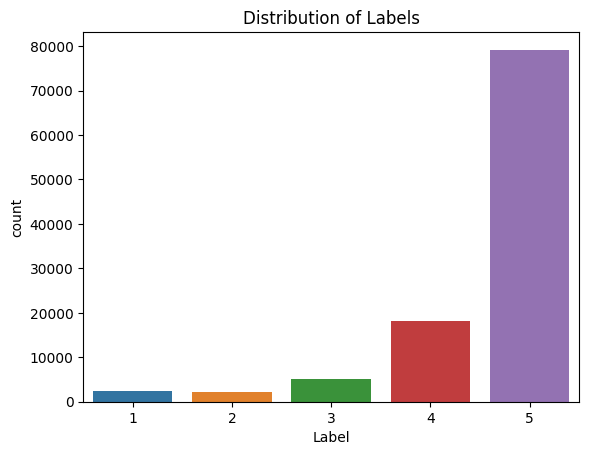

In [9]:
sns.countplot(x='Label',data=df)
plt.title('Distribution of Labels')
plt.show()

In [10]:
df.shape

(107018, 3)

**There are Total 107018 Reviews**

# Length of the Text 

In [11]:
df['text_length'] = df['Review'].apply(len)

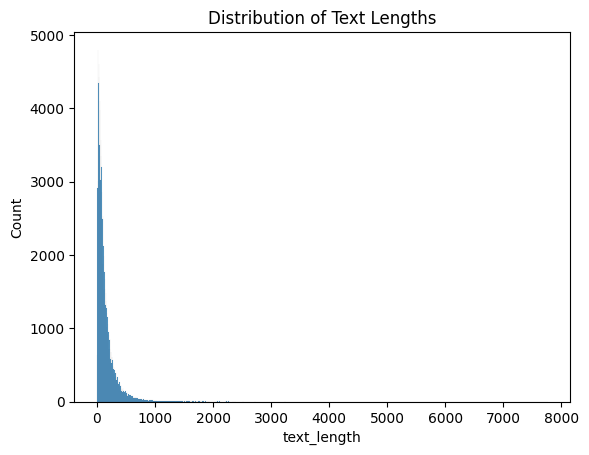

In [12]:
sns.histplot(x='text_length', data=df)
plt.title('Distribution of Text Lengths')
plt.show()

# Extract and seperate the data based on labels

In [13]:
train0=df[df['Label']==0]
train1=df[df['Label']==1]
train2=df[df['Label']==2]
train3=df[df['Label']==3]
train4=df[df['Label']==4]
train5=df[df['Label']==5]

# Peeking at the Distribution between each label

In [14]:
train0.shape, train1.shape, train2.shape, train3.shape, train4.shape, train5.shape

((0, 4), (2469, 4), (2251, 4), (5071, 4), (18054, 4), (79173, 4))

# Reducing the data of each label by 10

In [15]:
train0=train0[:int(train0.shape[0]/10)]
train1=train1[:int(train1.shape[0]/10)]
train2=train2[:int(train2.shape[0]/10)]
train3=train3[:int(train3.shape[0]/10)]
train4=train4[:int(train4.shape[0]/10)]
train5=train5[:int(train5.shape[0]/10)]

In [16]:
train0.shape, train1.shape, train2.shape, train3.shape, train4.shape, train5.shape

((0, 4), (246, 4), (225, 4), (507, 4), (1805, 4), (7917, 4))

In [17]:
df=pd.concat([train0,train1,train2,train3,train4,train5],axis=0)

In [18]:
df.shape

(10700, 4)

# Check for NULL

In [19]:
total_null = df.isnull().sum().sort_values(ascending = False)
percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending = False)
print("Total records = ", df.shape[0])

missing_data = pd.concat([total_null,percent.round(2)],axis=1,keys=['Total Missing','In Percent'])
missing_data.head(16)

Total records =  10700


,Total Missing,In Percent
Id,0,0.0
Review,0,0.0
Label,0,0.0
text_length,0,0.0


**GOOD NEWS**

In [20]:
df.head()

,Id,Review,Label,text_length
49,49,This course doesn't contain any new informatio...,1,159
71,71,I do not find very interesting this course. to...,1,186
79,79,A lot of speaking without any sense. Skip it a...,1,56
105,105,This course doesn't contain any new informatio...,1,159
173,173,It's not a course... this is a very short gene...,1,77


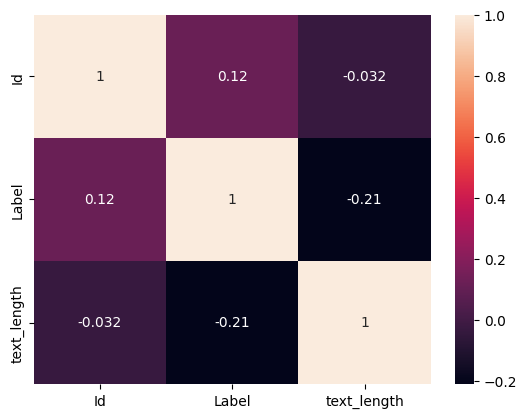

In [21]:
import seaborn as sns
ax = sns.heatmap(df.corr(),annot=True)

In [22]:
# We don't need the Id column. Let's drop it !
df.drop(columns=['Id'],inplace=True)
df.head()

,Review,Label,text_length
49,This course doesn't contain any new informatio...,1,159
71,I do not find very interesting this course. to...,1,186
79,A lot of speaking without any sense. Skip it a...,1,56
105,This course doesn't contain any new informatio...,1,159
173,It's not a course... this is a very short gene...,1,77


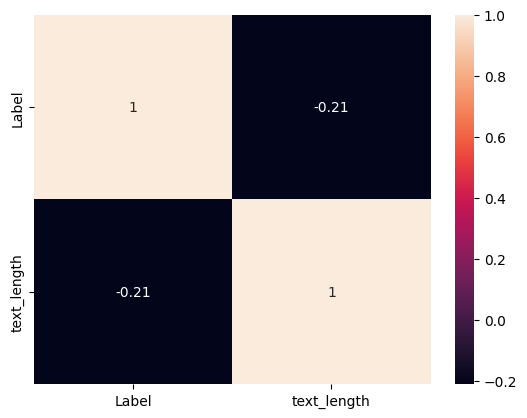

In [23]:
import seaborn as sns
ax = sns.heatmap(df.corr(),annot=True)

# DATA CLEANING

In [24]:
#remove hashtags
df['Review'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)
#Remove Mention
df['Review'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)
#Remove URL
df['Review'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

df['Review']=df['Review'].str.lower()

In [25]:
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [26]:
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# After Data Cleaning

In [27]:
df.head()

,Review,Label,text_length
49,course contain new information. teach excitedl...,1,159
71,find interesting course. many interviews. coul...,1,186
79,lot speaking without sense. skip cost,1,56
105,course contain new information. teach excitedl...,1,159
173,course... short general introduction 3d printing,1,77


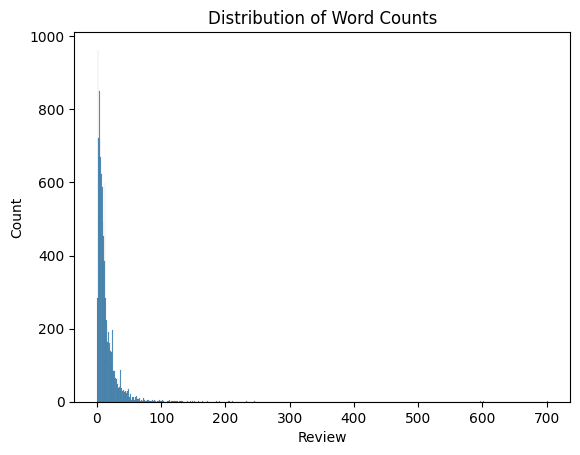

In [28]:
word_count = df['Review'].apply(lambda x: len(x.split()))
sns.histplot(word_count)
plt.title('Distribution of Word Counts')
plt.show()

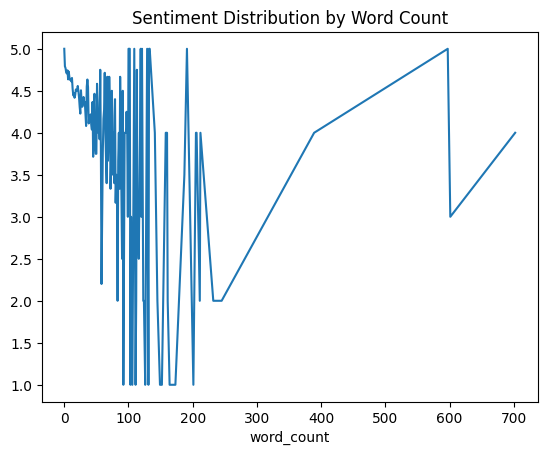

In [29]:
df['word_count'] = word_count
df.groupby('word_count')['Label'].mean().plot()
plt.title('Sentiment Distribution by Word Count')
plt.show()

# Label 1

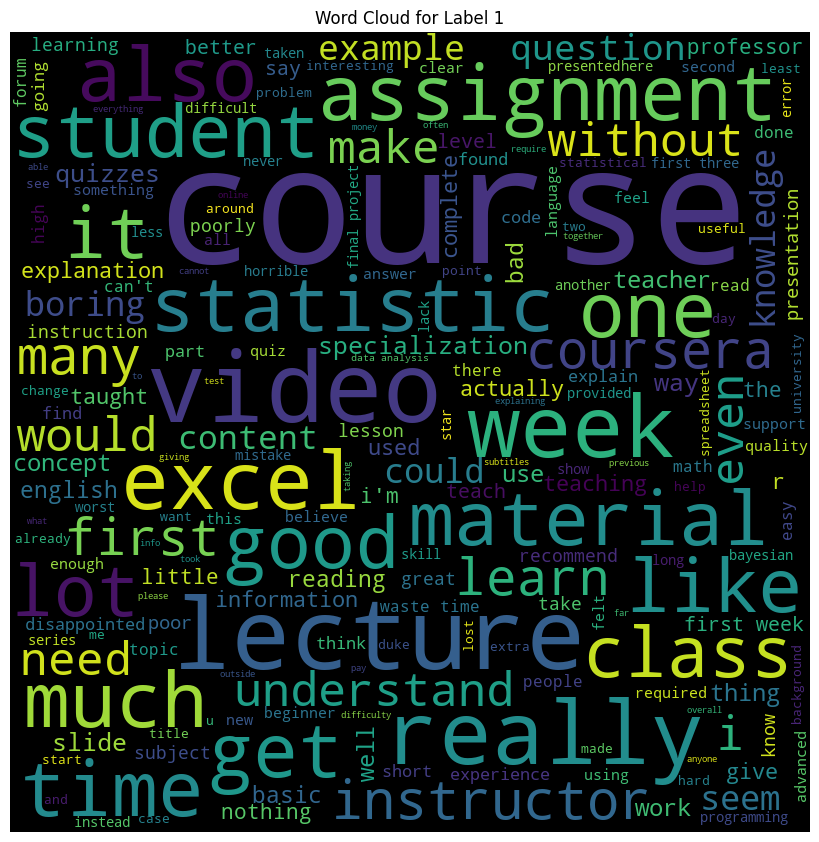

In [30]:
label1_texts = df[df['Label'] == 1]['Review']
label1_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(label1_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(label1_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Label 1')
plt.show()

# Label 2

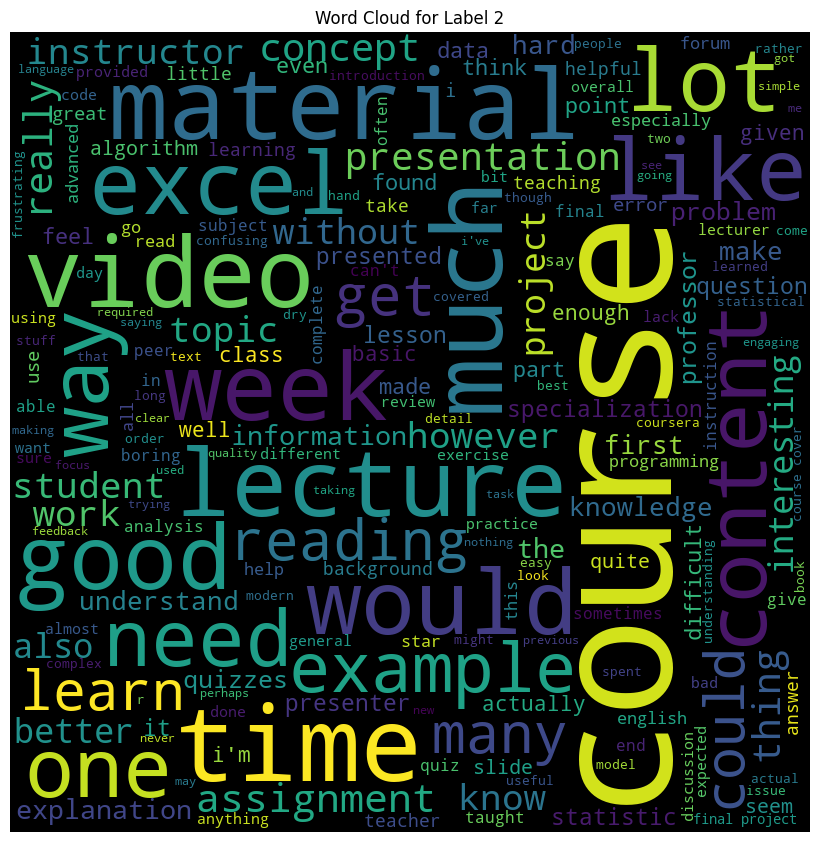

In [31]:
label2_texts = df[df['Label'] == 2]['Review']
label2_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(label2_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(label2_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Label 2')
plt.show()


# Label 3

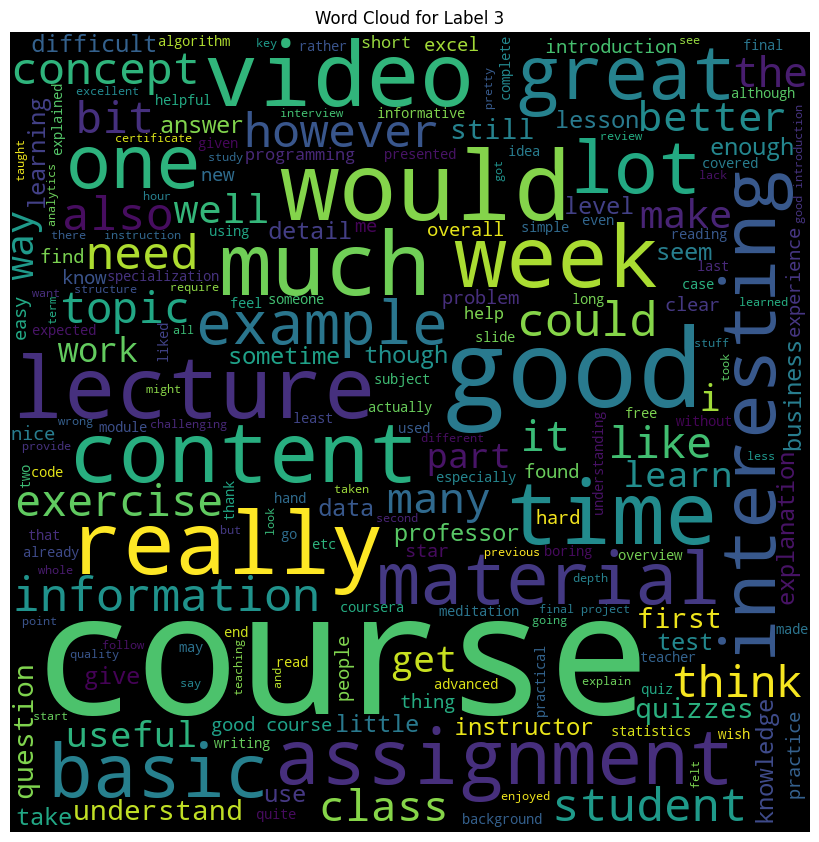

In [32]:
label3_texts = df[df['Label'] == 3]['Review']
label3_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(label3_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(label3_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Label 3')
plt.show()


# Label 4

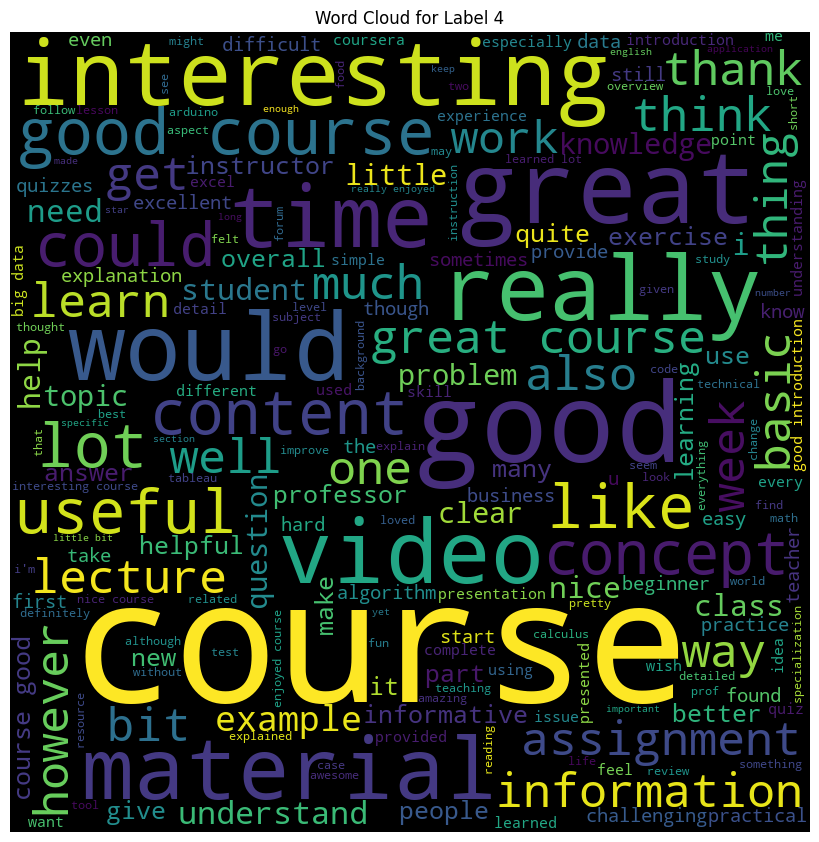

In [33]:
label4_texts = df[df['Label'] == 4]['Review']
label4_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(label4_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(label4_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Label 4')
plt.show()


# Label 5

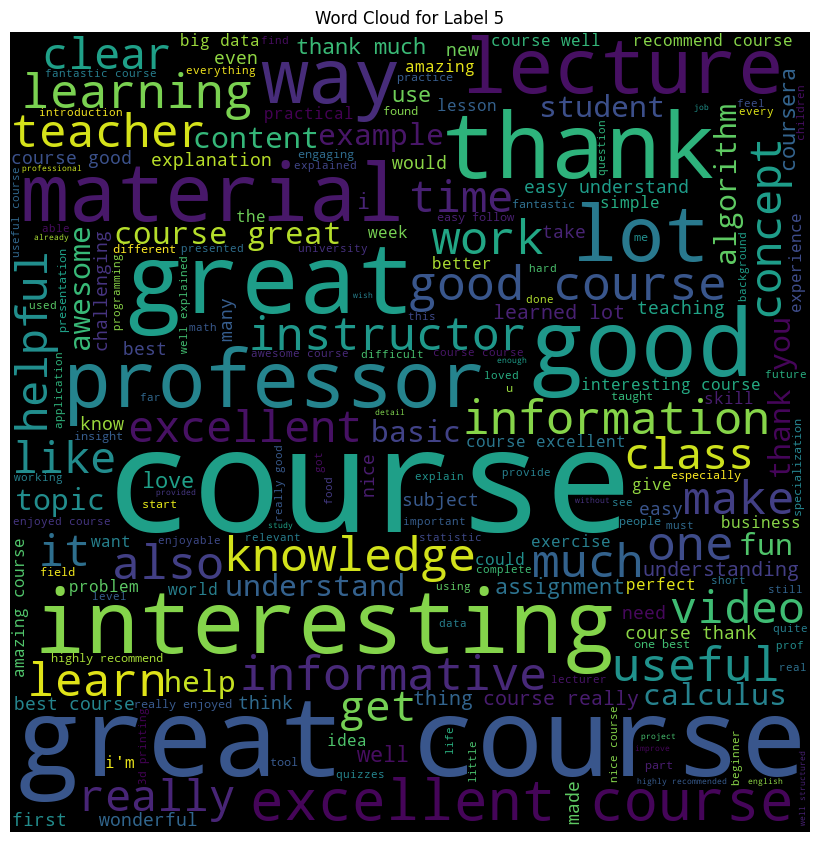

In [34]:
label5_texts = df[df['Label'] == 5]['Review']
label5_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(label5_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(label5_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Label 5')
plt.show()


# Stemming

In [35]:
from nltk.corpus import stopwords

nltk.download('stopwords')
ps = PorterStemmer()
df['Review'] = df['Review'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word not in set(stopwords.words('english'))]))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Punctuation Removal 

In [36]:
import string
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation
df['Review'] = df['Review'].apply(lambda x: ' '.join([token.text for token in nlp(x) if not token.is_punct]))


In [37]:
df.head()

,Review,Label,text_length,word_count
49,cours contain new information teach excitedli ...,1,159,14
71,find interest course mani interviews could wor...,1,186,14
79,lot speak without sense skip cost,1,56,6
105,cours contain new information teach excitedli ...,1,159,14
173,course short gener introduct 3d print,1,77,6


# Randomization

In [38]:
#randomization
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Review,Label,text_length,word_count
0,excellent learn new algorithm graphs,5,49,5
1,good course recommend,5,30,3
2,cours sens truli introduct big data domain dis...,5,316,30
3,best cours ever see learning,5,50,5
4,great combin theori practical give good unders...,5,93,9


# EDA for final Dataset

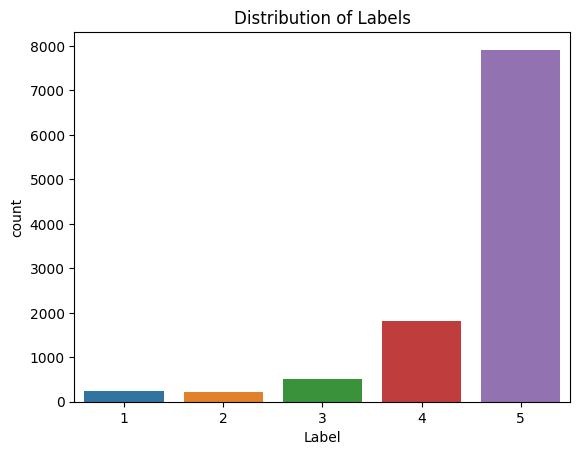

In [39]:
sns.countplot(x='Label',data=df)
plt.title('Distribution of Labels')
plt.show()

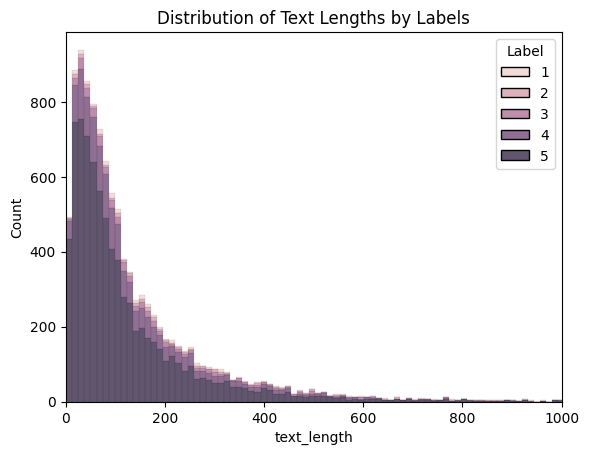

In [40]:
sns.histplot(x='text_length', data=df, hue='Label', multiple='stack')
plt.title('Distribution of Text Lengths by Labels')
plt.xlim(0, 1000)
plt.show()

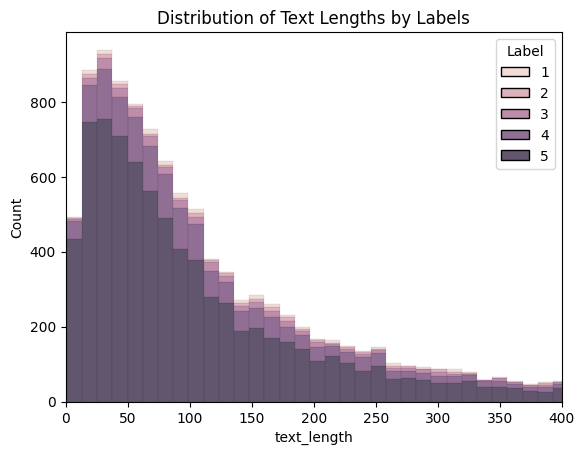

In [41]:
sns.histplot(x='text_length', data=df, hue='Label', multiple='stack')
plt.title('Distribution of Text Lengths by Labels')
plt.xlim(0, 400)
plt.show()

In [42]:
df.shape

(10700, 4)

In [43]:
df['Label'].value_counts()

5    7917
4    1805
3     507
1     246
2     225
Name: Label, dtype: int64

# Defining X and Y

In [44]:
y = df['Label']
x = df['Review']

# Vectorization

In [45]:
# Creating a word corpus for vectorization
corpus = []
for i in range(x.shape[0]):
    corpus.append(x.iloc[i])

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import csv
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
vectorizer1 = TfidfVectorizer(max_features=1000)
X1 = vectorizer1.fit_transform(x)
feature_names1 = vectorizer1.get_feature_names_out()
denselist1 = X1.todense().tolist()
train = pd.DataFrame(denselist1, columns=feature_names1)

In [48]:
# splitting the training and testing part from the data
X_temp, X_test, y_temp, y_test = train_test_split(train, y, test_size=0.2, random_state=0)


In [49]:
X_temp.shape, X_test.shape, y_temp.shape, y_test.shape

((8560, 1000), (2140, 1000), (8560,), (2140,))

In [50]:
df.head()

,Review,Label,text_length,word_count
0,excellent learn new algorithm graphs,5,49,5
1,good course recommend,5,30,3
2,cours sens truli introduct big data domain dis...,5,316,30
3,best cours ever see learning,5,50,5
4,great combin theori practical give good unders...,5,93,9


In [51]:
df1 = df.copy()

# TESTING with Models

# TF-IDF

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

In [53]:
accuracy = {'TF-IDF':[]}
accuracy

{'TF-IDF': []}

# Logistic Regression

In [54]:
#TF-IDF
regressor_LR_tf = LogisticRegression(C=1.0,penalty='l2',solver='newton-cg')
regressor_LR_tf.fit(X_temp, y_temp)
y_predict_LR_tf = regressor_LR_tf.predict(X_test)
a=(regressor_LR_tf.score(X_test, y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_LR_tf))
print(metrics.classification_report(y_test, y_predict_LR_tf))
print(metrics.accuracy_score(y_test, y_predict_LR_tf))

[[   2    0    1    9   46]
 [   1    0    3    8   22]
 [   0    1    3   34   71]
 [   1    0    0   72  282]
 [   0    0    1   53 1530]]
              precision    recall  f1-score   support

           1       0.50      0.03      0.06        58
           2       0.00      0.00      0.00        34
           3       0.38      0.03      0.05       109
           4       0.41      0.20      0.27       355
           5       0.78      0.97      0.87      1584

    accuracy                           0.75      2140
   macro avg       0.41      0.25      0.25      2140
weighted avg       0.68      0.75      0.69      2140

0.7509345794392523


# Decision Tree

In [55]:
#TF-IDF
model_DT_tf = DecisionTreeClassifier(criterion = 'gini', max_depth=2) 
model_DT_tf.fit(X_temp, y_temp)
y_predict_DT_tf = model_DT_tf.predict(X_test)
a=(model_DT_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_DT_tf))
print(metrics.classification_report(y_test, y_predict_DT_tf))
print(metrics.accuracy_score(y_test, y_predict_DT_tf))

[[   0    0    0    0   58]
 [   0    0    0    0   34]
 [   0    0    0    3  106]
 [   0    0    0   12  343]
 [   0    0    0    8 1576]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00       109
           4       0.52      0.03      0.06       355
           5       0.74      0.99      0.85      1584

    accuracy                           0.74      2140
   macro avg       0.25      0.21      0.18      2140
weighted avg       0.64      0.74      0.64      2140

0.7420560747663552


# Random Forest

In [56]:
#TF-IDF
model_RF_tf = RandomForestClassifier(n_estimators= 100, max_features = 'log2')
model_RF_tf.fit(X_temp, y_temp)
y_predict_RF_tf = model_RF_tf.predict(X_test)
a=(model_RF_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_RF_tf))
print(metrics.classification_report(y_test, y_predict_RF_tf))
print(metrics.accuracy_score(y_test, y_predict_RF_tf))

[[   3    0    0    1   54]
 [   0    0    0    4   30]
 [   1    0    1    9   98]
 [   0    0    1   21  333]
 [   0    0    2   10 1572]]
              precision    recall  f1-score   support

           1       0.75      0.05      0.10        58
           2       0.00      0.00      0.00        34
           3       0.25      0.01      0.02       109
           4       0.47      0.06      0.10       355
           5       0.75      0.99      0.86      1584

    accuracy                           0.75      2140
   macro avg       0.44      0.22      0.22      2140
weighted avg       0.67      0.75      0.65      2140

0.7462616822429906


# K Nearest Neighbours

In [57]:
#TF-IDF
model_KN_tf = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 5, weights= 'distance') 
model_KN_tf.fit(X_temp, y_temp)
y_predict_KN_tf = model_KN_tf.predict(X_test)
a=(model_KN_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_KN_tf))
print(metrics.classification_report(y_test, y_predict_KN_tf))
print(metrics.accuracy_score(y_test, y_predict_KN_tf))


[[   1    0    0    0   57]
 [   0    0    0    0   34]
 [   0    0    0    0  109]
 [   0    0    0    1  354]
 [   0    0    0    0 1584]]
              precision    recall  f1-score   support

           1       1.00      0.02      0.03        58
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00       109
           4       1.00      0.00      0.01       355
           5       0.74      1.00      0.85      1584

    accuracy                           0.74      2140
   macro avg       0.55      0.20      0.18      2140
weighted avg       0.74      0.74      0.63      2140

0.7411214953271028


# Gradient Boosting

In [58]:
#TF-IDF
model_GB_tf = GradientBoostingClassifier(learning_rate= 0.1, max_depth=3, n_estimators= 100,subsample=1.0) 
model_GB_tf.fit(X_temp, y_temp)
y_predict_GB_tf = model_GB_tf.predict(X_test)
a=(model_GB_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_GB_tf))
print(metrics.classification_report(y_test, y_predict_GB_tf))
print(metrics.accuracy_score(y_test, y_predict_GB_tf))

[[  10    1    0    4   43]
 [   2    2    1    5   24]
 [   2    1    3   23   80]
 [   0    3    3   48  301]
 [   1    5    1   25 1552]]
              precision    recall  f1-score   support

           1       0.67      0.17      0.27        58
           2       0.17      0.06      0.09        34
           3       0.38      0.03      0.05       109
           4       0.46      0.14      0.21       355
           5       0.78      0.98      0.87      1584

    accuracy                           0.75      2140
   macro avg       0.49      0.27      0.30      2140
weighted avg       0.69      0.75      0.69      2140

0.7546728971962616


# Evaluation

# Random Forest Using Grid Search CV

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [60]:
param_grid1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

In [61]:
grid_search = GridSearchCV(estimator=model_RF_tf, param_grid=param_grid1, cv=5)
grid_search.fit(X_temp, y_temp)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_features='log2'),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [62]:
y_predgridsearch = grid_search.predict(X_test)
a=(grid_search.score(X_test,y_test))
accuracy['TF-IDF'].append(a)
print(metrics.confusion_matrix(y_test, y_predgridsearch))
print(metrics.classification_report(y_test, y_predgridsearch))
print(metrics.accuracy_score(y_test, y_predgridsearch))

[[   0    0    0    0   58]
 [   0    0    0    0   34]
 [   0    0    0    0  109]
 [   0    0    0    0  355]
 [   0    0    0    0 1584]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00       109
           4       0.00      0.00      0.00       355
           5       0.74      1.00      0.85      1584

    accuracy                           0.74      2140
   macro avg       0.15      0.20      0.17      2140
weighted avg       0.55      0.74      0.63      2140

0.7401869158878505


# KNN using GridSearchCV

In [63]:
# from sklearn.neighbors import KNeighborsClassifier

In [64]:
# param_dist = {'n_neighbors': range(1, 21),
#               'weights': ['uniform', 'distance'],
#               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#               'p': [1, 2]}

In [65]:
# pip install --upgrade numpy

In [66]:
# grid_searchKNN = GridSearchCV(model_KN_tf,param_dist, cv=5,n_jobs=-1)
# grid_searchKNN.fit(X_temp, y_temp)


In [67]:
# y_predgridknnsearch = grid_searchKNN.predict(X_test)
# a=(grid_searchKNN.score(X_test,y_test))
# accuracy['TF-IDF'].append(a)
# print(metrics.confusion_matrix(y_test, y_predgridknnsearch))
# print(metrics.classification_report(y_test, y_predgridknnsearch))
# print(metrics.accuracy_score(y_test, y_predgridknnsearch))

# GRAPH 

In [68]:
model = ['LR','DT','RF','KN','GB','RFGCV']
data = {'model':model,'accuracy':accuracy['TF-IDF']}
compare_models = pd.DataFrame(data)
compare_models

,model,accuracy
0,LR,0.750935
1,DT,0.742056
2,RF,0.746262
3,KN,0.741589
4,GB,0.754673
5,RFGCV,0.740187


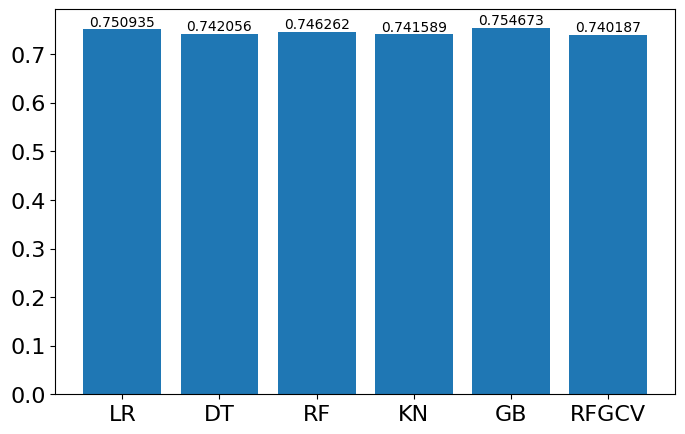

In [69]:
x, y = compare_models['model'],compare_models['accuracy']
ind = np.arange(len(y))
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(ind, y)
ax.set_xticks(ind)
ax.set_xticklabels(x)
ax.bar_label(ax.containers[0],)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()
fig.savefig('Comparision of Models, TFIDF.pdf', format='pdf', bbox_inches = "tight")

# BoW (Bag of Words)

In [70]:
df1.head()

,Review,Label,text_length,word_count
0,excellent learn new algorithm graphs,5,49,5
1,good course recommend,5,30,3
2,cours sens truli introduct big data domain dis...,5,316,30
3,best cours ever see learning,5,50,5
4,great combin theori practical give good unders...,5,93,9


In [71]:
x = df1['Review']

# Vectorizing

In [72]:
# Creating a word corpus for vectorization
corpus = []
for i in range(x.shape[0]):
    corpus.append(x.iloc[i])

In [73]:
vectorizer_train = CountVectorizer(max_features=1000)
vocabulary_train = vectorizer_train.fit_transform(corpus)
bow = pd.DataFrame(vocabulary_train.toarray(), columns = vectorizer_train.get_feature_names_out())

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [75]:
df.head()

,Review,Label,text_length,word_count
0,excellent learn new algorithm graphs,5,49,5
1,good course recommend,5,30,3
2,cours sens truli introduct big data domain dis...,5,316,30
3,best cours ever see learning,5,50,5
4,great combin theori practical give good unders...,5,93,9


**Attributes for ML model**

In [76]:
y = df1['Label']
x = df1['Review']

In [77]:
bow['labelxyz'] = df1.Label


In [78]:
bow_zero = bow[bow.labelxyz == 0]
bow_one = bow[bow.labelxyz == 1]
bow_two = bow[bow.labelxyz == 2]
bow_three = bow[bow.labelxyz == 3]
bow_four = bow[bow.labelxyz == 4]
bow_five = bow[bow.labelxyz == 5]

# Training & Testing

In [79]:
X_train_zero = bow_zero.sample(frac=0.8, random_state=0)
X_test_zero = bow_zero.drop(X_train_zero.index)
X_train_one = bow_one.sample(frac=0.8, random_state=0)
X_test_one = bow_one.drop(X_train_one.index)
X_train_two = bow_two.sample(frac=0.8, random_state=0)
X_test_two = bow_two.drop(X_train_two.index)
X_train_three = bow_three.sample(frac=0.8, random_state=0)
X_test_three = bow_three.drop(X_train_three.index)
X_train_four = bow_four.sample(frac=0.8, random_state=0)
X_test_four = bow_four.drop(X_train_four.index)
X_train_five = bow_five.sample(frac=0.8, random_state=0)
X_test_five = bow_five.drop(X_train_five.index)

In [80]:
X_train_df = pd.concat([X_train_zero, X_train_one, X_train_two, X_train_three, X_train_four, X_train_five], axis = 0)
bow_train = X_train_df.drop(['labelxyz'], axis = 1)
y_train = list(X_train_df.labelxyz)
X_test_df = pd.concat([X_test_zero, X_test_one, X_test_two, X_test_three, X_test_four, X_test_five], axis = 0)
bow_test = X_test_df.drop(['labelxyz'], axis = 1)
y_test = list(X_test_df.labelxyz)

# Building ML Model

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

In [82]:

accuracy = {'BOW':[]}
accuracy

{'BOW': []}

# Logistic Regression

In [83]:
#BOW
regressor_LR_bow = LogisticRegression(C= 1.0, penalty='l2', solver= 'liblinear')
regressor_LR_bow.fit(bow_train,y_train)
y_predict_LR_bow = regressor_LR_bow.predict(bow_test)
a=(regressor_LR_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_LR_bow))
print(metrics.classification_report(y_test, y_predict_LR_bow))
print(metrics.accuracy_score(y_test, y_predict_LR_bow))

[[   7    2    4    8   28]
 [   3    5    4    9   24]
 [   4    1    8   27   61]
 [   1    2   15   84  259]
 [   1    1    5   56 1520]]
              precision    recall  f1-score   support

           1       0.44      0.14      0.22        49
           2       0.45      0.11      0.18        45
           3       0.22      0.08      0.12       101
           4       0.46      0.23      0.31       361
           5       0.80      0.96      0.87      1583

    accuracy                           0.76      2139
   macro avg       0.47      0.31      0.34      2139
weighted avg       0.70      0.76      0.71      2139

0.7592332865825152


# Random Forest

In [84]:
#BOW
model_RF_bow = RandomForestClassifier(max_features='sqrt', n_estimators= 1000)
model_RF_bow.fit(bow_train,y_train)
y_predict_RF_bow = model_RF_bow.predict(bow_test)
a=(model_RF_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_RF_bow))
print(metrics.classification_report(y_test, y_predict_RF_bow))
print(metrics.accuracy_score(y_test, y_predict_RF_bow))

[[  10    0    0    7   32]
 [   1    0    0   10   34]
 [   0    0    4   31   66]
 [   0    0    5   74  282]
 [   1    0    5   52 1525]]
              precision    recall  f1-score   support

           1       0.83      0.20      0.33        49
           2       0.00      0.00      0.00        45
           3       0.29      0.04      0.07       101
           4       0.43      0.20      0.28       361
           5       0.79      0.96      0.87      1583

    accuracy                           0.75      2139
   macro avg       0.47      0.28      0.31      2139
weighted avg       0.69      0.75      0.70      2139

0.7540906965871903


# Decision Tree 

In [85]:
#BOW
model_DT_bow = RandomForestClassifier(criterion= 'gini', max_depth= 2)
model_DT_bow.fit(bow_train,y_train)
y_predict_DT_bow = model_DT_bow.predict(bow_test)
a=(model_DT_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_DT_bow))
print(metrics.classification_report(y_test, y_predict_DT_bow))
print(metrics.accuracy_score(y_test, y_predict_DT_bow))

[[   0    0    0    0   49]
 [   0    0    0    0   45]
 [   0    0    0    0  101]
 [   0    0    0    0  361]
 [   0    0    0    0 1583]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00        45
           3       0.00      0.00      0.00       101
           4       0.00      0.00      0.00       361
           5       0.74      1.00      0.85      1583

    accuracy                           0.74      2139
   macro avg       0.15      0.20      0.17      2139
weighted avg       0.55      0.74      0.63      2139

0.740065451145395


In [86]:
accuracy

{'BOW': [0.7592332865825152, 0.7540906965871903, 0.740065451145395]}

# K neighbours

In [87]:
#BOW
model_KN_bow = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 5, weights= 'distance') 
model_KN_bow.fit(bow_train,y_train)
y_predict_KN_bow = model_KN_bow.predict(bow_test)
a=(model_KN_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_KN_bow))
print(metrics.classification_report(y_test, y_predict_KN_bow))
print(metrics.accuracy_score(y_test, y_predict_KN_bow))

[[   5    0    0    4   40]
 [   0    0    1    4   40]
 [   0    0    2    5   94]
 [   1    0    2   19  339]
 [   0    2    4   47 1530]]
              precision    recall  f1-score   support

           1       0.83      0.10      0.18        49
           2       0.00      0.00      0.00        45
           3       0.22      0.02      0.04       101
           4       0.24      0.05      0.09       361
           5       0.75      0.97      0.84      1583

    accuracy                           0.73      2139
   macro avg       0.41      0.23      0.23      2139
weighted avg       0.62      0.73      0.65      2139

0.7274427302477794


# Gradient Boosting

In [88]:
#BOW
model_GB_bow = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 100, subsample= 1.0)
model_GB_bow.fit(bow_train,y_train)
y_predict_GB_bow = model_GB_bow.predict(bow_test)
a=(model_GB_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_GB_bow))
print(metrics.classification_report(y_test, y_predict_GB_bow))
print(metrics.accuracy_score(y_test, y_predict_GB_bow))

[[   4    4    3    5   33]
 [   1    5    0    4   35]
 [   3    0    2   20   76]
 [   1    2    4   48  306]
 [   3    5    2   18 1555]]
              precision    recall  f1-score   support

           1       0.33      0.08      0.13        49
           2       0.31      0.11      0.16        45
           3       0.18      0.02      0.04       101
           4       0.51      0.13      0.21       361
           5       0.78      0.98      0.87      1583

    accuracy                           0.75      2139
   macro avg       0.42      0.27      0.28      2139
weighted avg       0.68      0.75      0.69      2139

0.7545582047685835


# Random Forest using Grid Search CV

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

In [90]:
grid_searchbow = GridSearchCV(estimator=model_RF_bow, param_grid=param_grid1, cv=2)
grid_searchbow.fit(bow_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_estimators=1000),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [91]:
y_predgridsearchbow = grid_searchbow.predict(bow_test)
a=(grid_searchbow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predgridsearchbow))
print(metrics.classification_report(y_test, y_predgridsearchbow))
print(metrics.accuracy_score(y_test, y_predgridsearchbow))

[[   0    0    0    1   48]
 [   0    0    0    0   45]
 [   0    0    0    5   96]
 [   0    0    0    1  360]
 [   0    0    0    1 1582]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00        45
           3       0.00      0.00      0.00       101
           4       0.12      0.00      0.01       361
           5       0.74      1.00      0.85      1583

    accuracy                           0.74      2139
   macro avg       0.17      0.20      0.17      2139
weighted avg       0.57      0.74      0.63      2139

0.740065451145395


In [92]:
# accuracy['BOW'].append(0.7414679756895746)

In [93]:
accuracy

{'BOW': [0.7592332865825152,
  0.7540906965871903,
  0.740065451145395,
  0.7274427302477794,
  0.7545582047685835,
  0.740065451145395]}

In [94]:
accuracy = {'BOW': accuracy['BOW'][:6]}

# KNN using Grid Search CV

In [95]:
# from sklearn.neighbors import KNeighborsClassifier
# param_grid1 = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10]
# }

In [96]:
# grid_searchKNNbow = GridSearchCV(model_KN_bow,param_dist, cv=5,n_jobs=-1)
# grid_searchKNNbow.fit(bow_train, y_train)


In [97]:
# y_predgridknnsearchbow = grid_searchKNNbow.predict(bow_test)
# a=(grid_searchKNNbow.score(bow_test,y_test))
# accuracy['BOW'].append(a)
# print(metrics.confusion_matrix(y_test, y_predgridknnsearchbow))
# print(metrics.classification_report(y_test, y_predgridknnsearchbow))
# print(metrics.accuracy_score(y_test, y_predgridknnsearchbow))

In [98]:
model = ['LR','RF','DT','KN','GB','RFGCV']
data_bow = {'model':model,'accuracy':accuracy['BOW']}
compare_models_bow = pd.DataFrame(data_bow)
compare_models_bow

,model,accuracy
0,LR,0.759233
1,RF,0.754091
2,DT,0.740065
3,KN,0.727443
4,GB,0.754558
5,RFGCV,0.740065


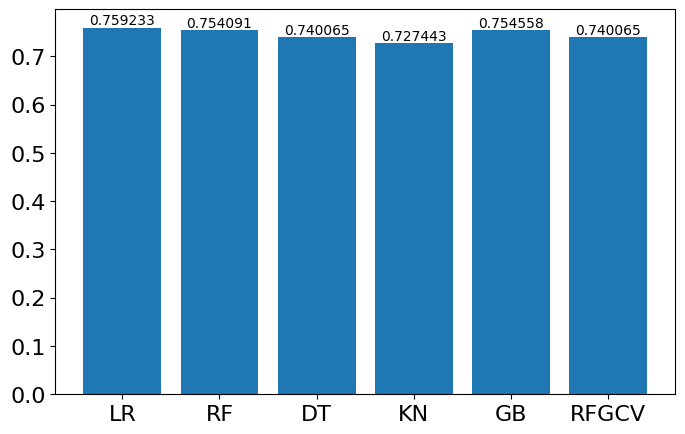

In [99]:
x, y = compare_models_bow['model'],compare_models_bow['accuracy']
ind = np.arange(len(y))
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(ind, y)
ax.set_xticks(ind)
ax.set_xticklabels(x)
ax.bar_label(ax.containers[0],)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()
fig.savefig('Comparision of Models, BOW.pdf', format='pdf', bbox_inches = "tight")

# CONCLUSION

**We evaluated five different machine learning models on a Course Era Review dataset, and the results showed that the vectorization and bag of words strategies produced good accuracy levels. We used the decision tree, random forest, KNN, logistic regressiontechniques. For each model, we have optimized the performance using hyperparameter tuning.**



**We used the Term Frequency-Inverse Document Frequency (TF-IDF) method for the vectorization technique and the Count Vectorization for the bag of words method. 
The model trained using the vectorization strategy with the highest accuracy was Logistic Regression (75%)
The model trained using the BOW method with the highhest accuracy was Logistic Regression(75%)**